In [1]:
import sys

import timeit
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

sys.path.append('/home/hoheon/packages/')

from utils.keras import get_model_memory_usage
from utils.numpy import to_onehot

tf.enable_eager_execution()

In [2]:
# Given data
train, test = tf.keras.datasets.cifar10.load_data()
x_train, y_train = train[0], train[1]
x_test, y_test = test[0], test[1]

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3)

y_train = to_onehot(y_train, 10).reshape(-1, 10)
y_val = to_onehot(y_val, 10).reshape(-1, 10)
y_test = to_onehot(y_test, 10).reshape(-1, 10)

print(x_train.shape, y_train.shape)
print("N classes: {}".format(y_test.shape[-1]))

(35000, 32, 32, 3) (35000, 10)
N classes: 10


##### Model

In [3]:
sub_model = tf.keras.applications.VGG19(include_top=False, input_shape=(32, 32, 3), classes=10, weights=None)
sub_model.trainable = False

flat = tf.keras.layers.Flatten()(sub_model.layers[-1].output)
classify_ = tf.keras.layers.Dense(10, activation='softmax')(flat)
model = tf.keras.Model(inputs=sub_model.inputs, outputs=classify_)
model.compile(optimizer=tf.keras.optimizers.Adam(0.05), loss='categorical_crossentropy', metrics=['accuracy'])


In [4]:
model.load_weights('./cache/best_param.hdf5')

##### Runtime

In [5]:
def layer_runtime(index, batch, model, repeat=150, return_size=False):
    '''
    Parameters
    ----------
    index: int:
        layer index
    model: keras.model
    repeate: int
    
    Return
    ------
    runtime: [sec, sec, sec...] 
    dsize: /kbyte
    '''
    
    runtimes = []
    for _ in range(repeat):
    
        front_model = tf.keras.Model(model.input, model.layers[index-1].output)
        front_output = front_model(batch)
        
        start_time = timeit.default_timer()
        model.layers[index](front_output)
        end_time = timeit.default_timer()
        
        runtime = end_time - start_time
        runtimes.append(runtime)
        
    if return_size == False:
        return runtimes
    else:
        return_val = model.layers[index](front_output).numpy()
            
        mem_size = return_val.nbytes / 1024
        return runtimes, mem_size


resource_consump = dict()

for i in range(0, len(model.layers)):
    runtimes, d_size = layer_runtime(i, tf.convert_to_tensor(x_train[0:1], dtype='float32'), model, return_size=True)
    
    l_name = model.layers[i].name
    resource_consump[l_name] = {'runtime':runtimes, 'dsize':d_size}

In [6]:
df = []

for layer_name in list(resource_consump.keys()):
    _df = pd.DataFrame(resource_consump[layer_name]['runtime'])
    _df['layer_name'] = layer_name
    df.append(_df)
    
runtimes = pd.concat(df)
runtimes.columns = ['runtime', 'layer_name']
runtimes.head(2)

,runtime,layer_name
0,0.000758,input_1
1,0.000588,input_1


In [7]:
df = []
for layer_name in list(resource_consump.keys()):
    _dsize = resource_consump[layer_name]['dsize']
    df.append([layer_name, _dsize])
    
d_size = pd.DataFrame(df)
d_size.columns = ['layer_name', 'dsize']
d_size.head(2)

,layer_name,dsize
0,input_1,0.039062
1,block1_conv1,256.000000


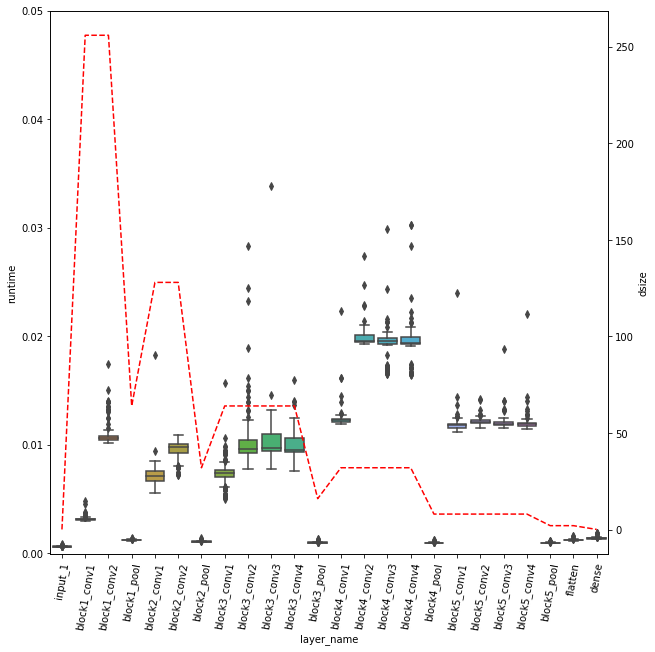

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(10 ,10))
sns.boxplot(y='runtime', x='layer_name', data=runtimes, orient='v')


plt.ylim(-0.0001, 0.05)
plt.xticks(rotation=80)

ax2 = plt.twinx()
sns.lineplot(x='layer_name', y='dsize', data=d_size, ax=ax2, markers='*', color='red', linestyle='--')

In [9]:
runtimes.to_csv('./cache/device_runtime_batch1.csv', index=False)

##### 100 batches

In [10]:
def layer_runtime(index, batch, model, repeat=150, return_size=False):
    '''
    Parameters
    ----------
    index: int:
        layer index
    model: keras.model
    repeate: int
    
    Return
    ------
    runtime: [sec, sec, sec...] 
    dsize: /kbyte
    '''
    
    runtimes = []
    for _ in range(repeat):
    
        front_model = tf.keras.Model(model.input, model.layers[index-1].output)
        front_output = front_model(batch)
        
        start_time = timeit.default_timer()
        model.layers[index](front_output)
        end_time = timeit.default_timer()
        
        runtime = end_time - start_time
        runtimes.append(runtime)
        
    if return_size == False:
        return runtimes
    else:
        return_val = model.layers[index](front_output).numpy()
            
        mem_size = return_val.nbytes / 1024
        return runtimes, mem_size


resource_consump = dict()

for i in range(0, len(model.layers)):
    runtimes, d_size = layer_runtime(i, 
                                     tf.convert_to_tensor(x_train[0:30], dtype='float32'), 
                                     model, 
                                     return_size=True)
    
    l_name = model.layers[i].name
    resource_consump[l_name] = {'runtime':runtimes, 'dsize':d_size}

In [11]:
df = []

for layer_name in list(resource_consump.keys()):
    _df = pd.DataFrame(resource_consump[layer_name]['runtime'])
    _df['layer_name'] = layer_name
    df.append(_df)
    
runtimes = pd.concat(df)
runtimes.columns = ['runtime', 'layer_name']
runtimes.head(2)

,runtime,layer_name
0,0.000661,input_1
1,0.000754,input_1


In [12]:
df = []
for layer_name in list(resource_consump.keys()):
    _dsize = resource_consump[layer_name]['dsize']
    df.append([layer_name, _dsize])
    
d_size = pd.DataFrame(df)
d_size.columns = ['layer_name', 'dsize']
d_size.head(2)

,layer_name,dsize
0,input_1,1.171875
1,block1_conv1,7680.000000


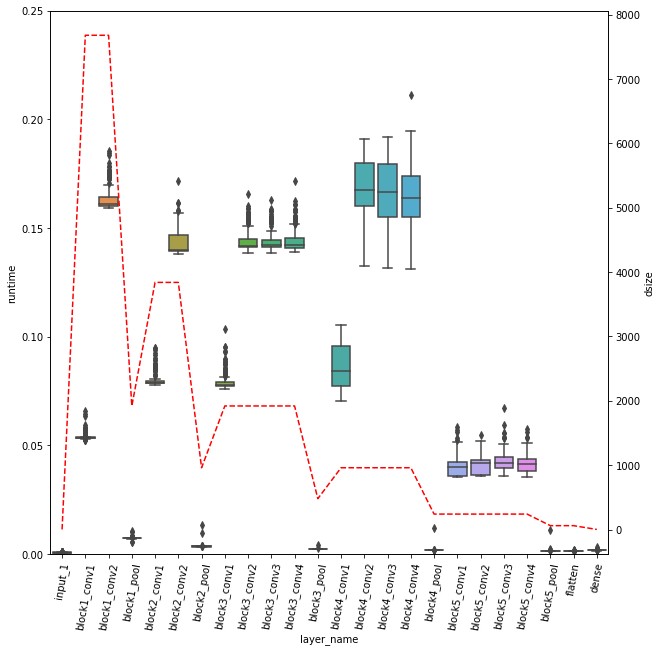

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(10 ,10))
sns.boxplot(y='runtime', x='layer_name', data=runtimes, orient='v')


plt.ylim(-0.0001, 0.25)
plt.xticks(rotation=80)

ax2 = plt.twinx()
sns.lineplot(x='layer_name', y='dsize', data=d_size, ax=ax2, markers='*', color='red', linestyle='--')